In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import Window, functions as F

from kloppy.helpers import load_wyscout_event_data
from kloppy_spark import Pipeline, Source, Sink
from kloppy_spark.stages import *
from kloppy_spark.sinks import *
from kloppy_spark.sources import *

from deepsports.experimental.tactical import kloppy as kp

In [2]:
dataset = load_wyscout_event_data("wyscout_events.json")

In [3]:
%%time
sc = pyspark.SparkContext(appName="kloppy")

CPU times: user 9.41 ms, sys: 12.3 ms, total: 21.7 ms
Wall time: 5.64 s


+-----------+---------+-----+
|  timestamp|period_id|score|
+-----------+---------+-----+
| 2999.70982|       2H|  4:2|
|2994.826943|       2H|  4:2|
|2994.826943|       2H|  4:2|
|2993.428163|       2H|  4:2|
|2961.352416|       2H|  4:2|
|2959.112093|       2H|  4:2|
|2958.885587|       2H|  4:2|
|2956.940653|       2H|  4:2|
|2954.090128|       2H|  4:2|
|2951.476805|       2H|  4:2|
|2949.141555|       2H|  4:2|
|2947.113585|       2H|  4:2|
|2944.669009|       2H|  4:2|
|2943.016301|       2H|  4:2|
|2941.235501|       2H|  4:2|
|2939.440383|       2H|  4:2|
|2926.734556|       2H|  4:2|
|2924.628859|       2H|  4:2|
| 2922.18409|       2H|  4:2|
|2921.026852|       2H|  4:2|
+-----------+---------+-----+
only showing top 20 rows

CPU times: user 266 ms, sys: 32.7 ms, total: 299 ms
Wall time: 11.7 s


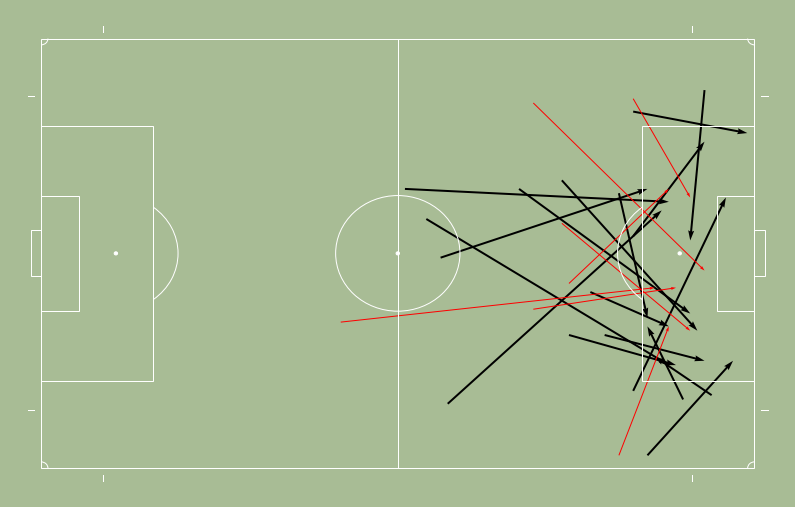

In [4]:
%%time

teams = list(dataset.metadata.teams)

# Create a Spark pipeline to load and pre-process a Kloppy Event DataSet
proc_pipe = Pipeline("kloppy::wyscout", sc) \
    & ("data", DatasetSource(dataset)) \
    | ("data", "transformed", CoordinateTransformer(
        from_dim=dataset.metadata.pitch_dimensions,
        to_dim=kp.PITCH_105_68))
    
# Calculate all passes of the home team into the ATTACKING_BOX
proc_pipe \
    | ("transformed", "passes", PassesIntoZone(kp.zones.ATTACKING_BOX, teams[0].team_id)) \
    | ("passes", "zone_pases_plot", kp.PlotPasses())

# Calculate the score for each event
proc_pipe \
    | ("data", "score", Score(teams[0].team_id, teams[1].team_id)) \
    | ("score", "show_score", ShowDataFrame(["timestamp", "period_id", "score"], tail=True)) 

proc_pipe.run()

In [5]:
%%time


sequences = None
    
class Collect(Sink):
    def process(self, pipeline, inputs: pyspark.sql.DataFrame) -> None:
        global sequences
        sequences = inputs.collect()


# Create a Spark pipeline to load and pre-process a Kloppy Event DataSet
proc_pipe = Pipeline("kloppy::wyscout", sc) \
    & ("data", DatasetSource(dataset)) \
    | ("data", "transformed", CoordinateTransformer(
        from_dim=dataset.metadata.pitch_dimensions,
        to_dim=kp.PITCH_105_68)) \
    | ("transformed", "seq", Sequences()) \
    | ("seq", "debug", Collect())


proc_pipe.run()

print(len(sequences))

5
CPU times: user 298 ms, sys: 606 ms, total: 904 ms
Wall time: 2.76 s
